In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataflow import df_train, df_test, df_geography, df_product

# 1. Kiểm chứng các tính chất chuỗi thời gian

In [2]:
# Kết nối tự nhiên giữa các bảng
df = df_train.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901561 entries, 0 to 901560
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ProductID  901561 non-null  int64         
 1   Date       901561 non-null  datetime64[ns]
 2   Zip        901561 non-null  int64         
 3   Units      901561 non-null  int64         
 4   Revenue    901561 non-null  float64       
 5   COGS       901561 non-null  float64       
 6   City       901561 non-null  object        
 7   State      901561 non-null  object        
 8   Region     901561 non-null  object        
 9   District   901561 non-null  object        
 10  Category   901561 non-null  object        
 11  Segment    901561 non-null  object        
 12  Product    901561 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 89.4+ MB


In [4]:
# Tạo các cột năm, tháng và quý
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

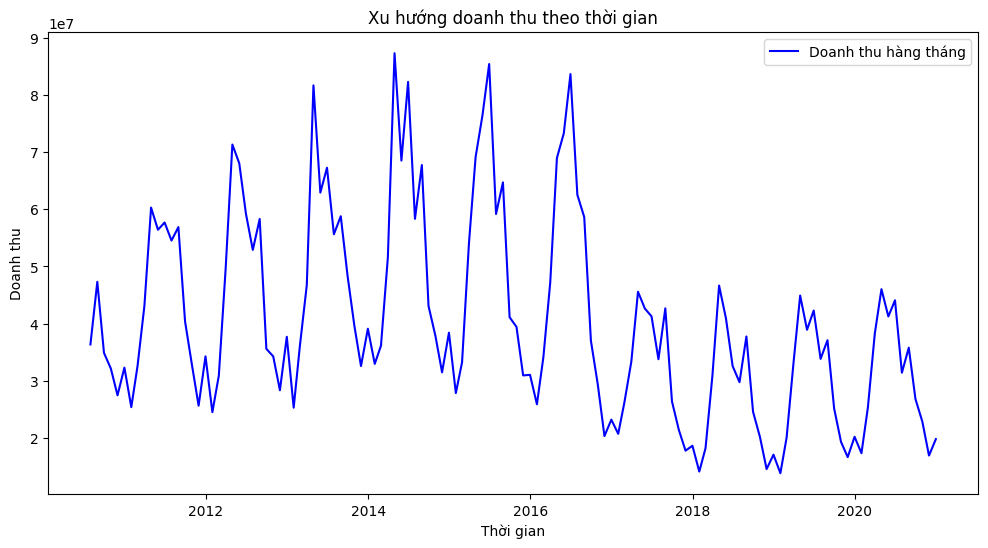

In [ ]:


# Gom nhóm theo tháng
df_monthly = df.groupby(pd.Grouper(key='Date', freq='ME')).agg({'Revenue': 'sum', 'Units': 'sum'}).reset_index()

# Vẽ biểu đồ xu hướng doanh thu theo thời gian
plt.figure(figsize=(12,6))
plt.plot(df_monthly['Date'], df_monthly['Revenue'], label='Doanh thu hàng tháng', color='blue')
plt.title("Xu hướng doanh thu theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("Doanh thu")
plt.legend()
plt.show()

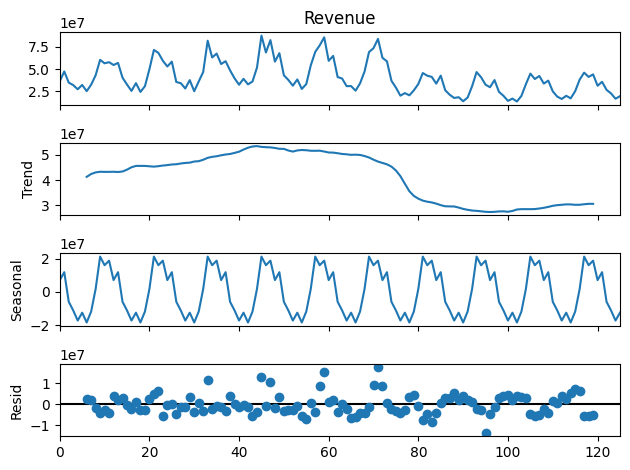

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Sử dụng seasonal_decompose với khoảng chu kỳ là 12 tháng
result = seasonal_decompose(df_monthly['Revenue'], model='additive', period=12)
result.plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_monthly['Revenue'])
print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])

if adf_result[1] > 0.05:
	print("Chuỗi không dừng")
else:
	print("Chuỗi dừng")

ADF Statistic: -0.603644
p-value: 0.870156
Chuỗi không dừng


In [12]:
df_monthly['Revenue_diff'] = df_monthly['Revenue'].diff()

# Kiểm định ADF sau khi lấy hiệu sai
adf_result_diff = adfuller(df_monthly['Revenue_diff'].dropna())
print("ADF Statistic after differencing: %f" % adf_result_diff[0])
print("p-value after differencing: %f" % adf_result_diff[1])

if adf_result_diff[1] > 0.05:
    print("Chuỗi vẫn không dừng, cần tiếp tục lấy hiệu sai")
else:
    print("Chuỗi đã dừng, có thể áp dụng mô hình dự báo")

ADF Statistic after differencing: -4.117726
p-value after differencing: 0.000905
Chuỗi đã dừng, có thể áp dụng mô hình dự báo


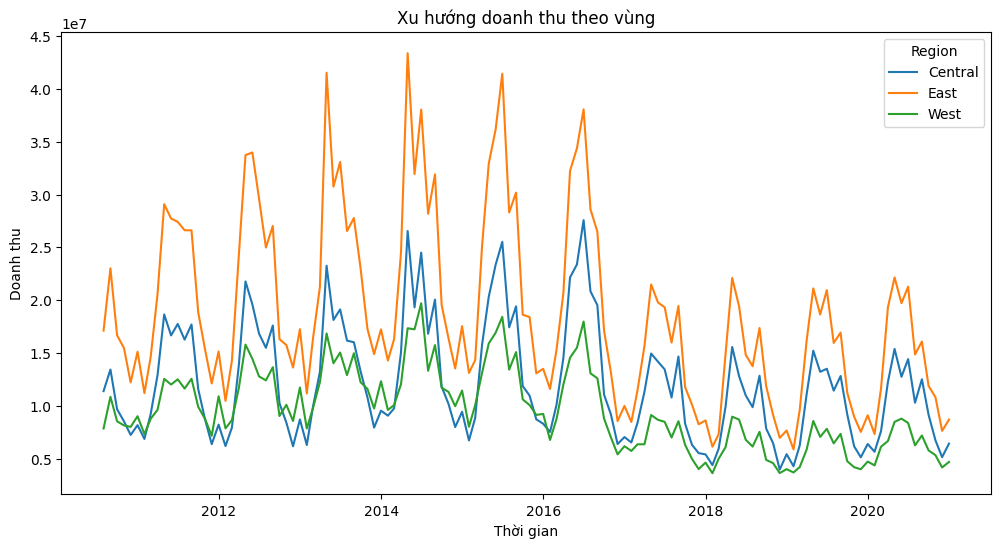

In [10]:
import seaborn as sns

# Gom nhóm theo tháng và vùng
df_region_monthly = df.groupby([pd.Grouper(key='Date', freq='ME'), 'Region']).agg({'Revenue': 'sum'}).reset_index()

# Vẽ biểu đồ xu hướng doanh thu theo từng vùng
plt.figure(figsize=(12,6))
sns.lineplot(data=df_region_monthly, x='Date', y='Revenue', hue='Region')
plt.title("Xu hướng doanh thu theo vùng")
plt.xlabel("Thời gian")
plt.ylabel("Doanh thu")
plt.show()

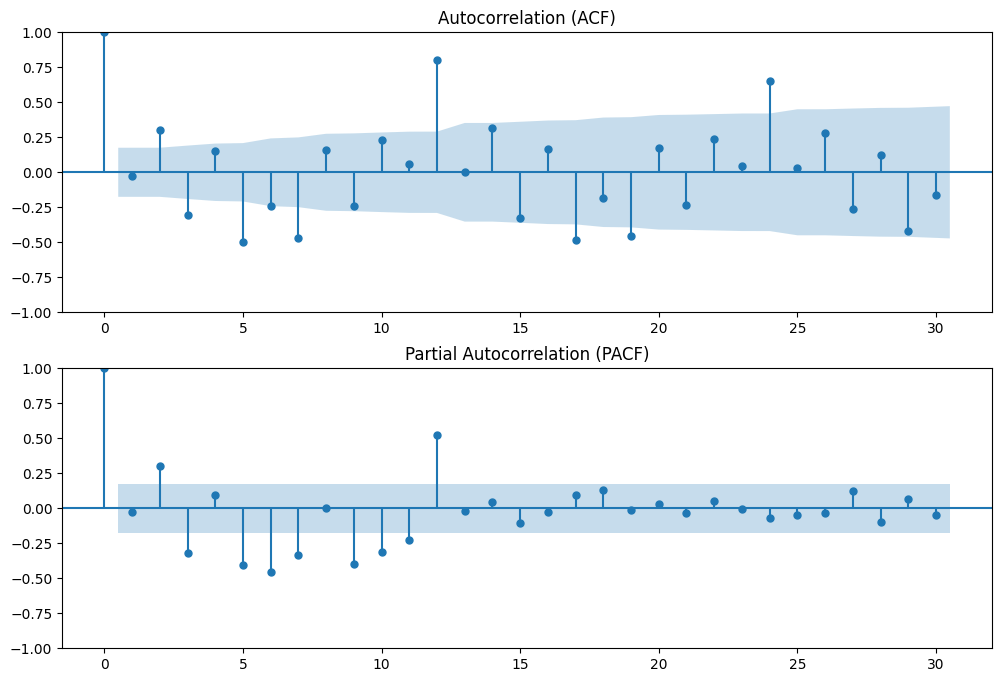

In [13]:
import statsmodels.api as sm

fig, ax = plt.subplots(2, 1, figsize=(12,8))

# Vẽ biểu đồ ACF (tự tương quan)
sm.graphics.tsa.plot_acf(df_monthly['Revenue_diff'].dropna(), lags=30, ax=ax[0])
ax[0].set_title("Autocorrelation (ACF)")

# Vẽ biểu đồ PACF (tự tương quan riêng phần)
sm.graphics.tsa.plot_pacf(df_monthly['Revenue_diff'].dropna(), lags=30, ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF)")

plt.show()

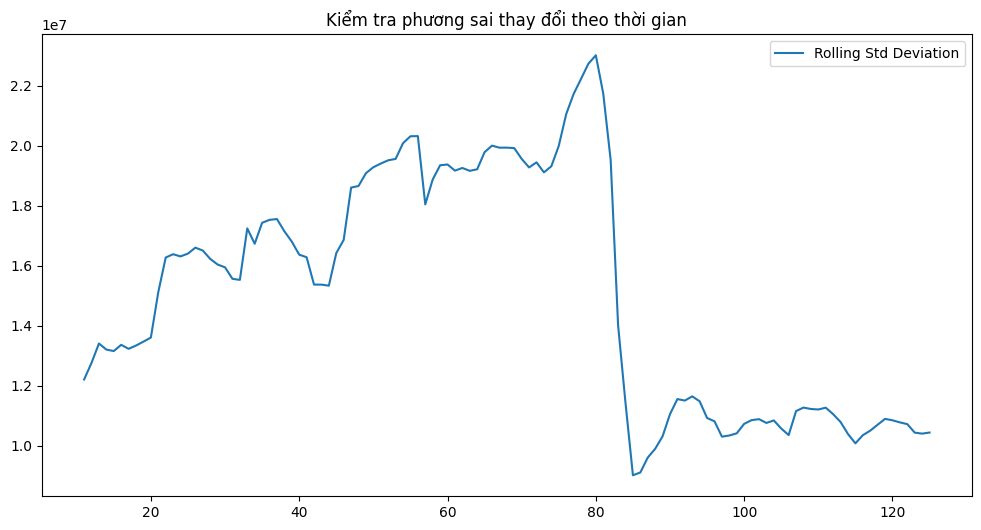

In [14]:
df_monthly['Rolling_Std'] = df_monthly['Revenue'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(df_monthly['Rolling_Std'], label="Rolling Std Deviation")
plt.title("Kiểm tra phương sai thay đổi theo thời gian")
plt.legend()
plt.show()

In [15]:
import numpy as np

df_monthly['Revenue_log'] = np.log(df_monthly['Revenue'])
df_monthly['Revenue_log_diff'] = df_monthly['Revenue_log'].diff()

# Kiểm định ADF lại trên dữ liệu log-transformed
adf_result_log_diff = adfuller(df_monthly['Revenue_log_diff'].dropna())
print("ADF Statistic after log transform: %f" % adf_result_log_diff[0])
print("p-value after log transform: %f" % adf_result_log_diff[1])

ADF Statistic after log transform: -2.498415
p-value after log transform: 0.115860
